# 5. Quick Visualization for Hyperparameter Optimization Analysis

Optuna provides various visualization features in :mod:`optuna.visualization` to analyze optimization results visually.

This tutorial walks you through this module by visualizing the history of lightgbm model for breast cancer dataset.

For visualizing multi-objective optimization (i.e., the usage of :func:`optuna.visualization.plot_pareto_front`),
please refer to the tutorial of `multi_objective`.

In [2]:
# Install lightgbm and optuna
import sys
!{sys.executable} -m pip install lightgbm
!{sys.executable} -m pip install optuna

  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=64c4f7c4a15a66aa2099ac39b0dea77dc38302b3d0d1f6a9dd6c863fd4c9ae2a
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\0c\09\9e\49e21a6840ef7955b06d47394afef0058f0378c0914e48b8b8
Successfully built pyperclip


In [20]:
import lightgbm as lgb
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
import mlflow
import optuna

# You can use Matplotlib instead of Plotly for visualization by simply replacing `optuna.visualization` with
# `optuna.visualization.matplotlib` in the following examples.
from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_slice

from optuna.integration.mlflow import MLflowCallback



SEED = 42

np.random.seed(SEED)

## Define the objective function

In [4]:
def objective(trial):
    data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)
    dvalid = lgb.Dataset(valid_x, label=valid_y)

    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
    gbm = lgb.train(param, dtrain, valid_sets=[dvalid], 
                    verbose_eval=False, callbacks=[pruning_callback])

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy

In [22]:
tracking_uri = mlflow.get_tracking_uri()
mlflc = MLflowCallback(tracking_uri=tracking_uri,
                       metric_name="my metric score",)

C:\Users\user\AppData\Local\Temp\ipykernel_13184\1241558967.py:2: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflc = MLflowCallback(tracking_uri=tracking_uri,


In [23]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
)
study.optimize(objective, n_trials=100, timeout=600, callbacks=[mlflc])

[I 2022-08-30 20:51:17,659] A new study created in memory with name: no-name-9048699d-2e90-45c3-bfe3-7ec95622f594
[I 2022-08-30 20:51:17,721] Trial 0 finished with value: 0.972027972027972 and parameters: {'bagging_fraction': 0.6247240713084175, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 0 with value: 0.972027972027972.
2022/08/30 20:51:17 INFO mlflow.tracking.fluent: Experiment with name 'no-name-9048699d-2e90-45c3-bfe3-7ec95622f594' does not exist. Creating a new experiment.
2022/08/30 20:51:17 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the futur

[I 2022-08-30 20:51:26,298] Trial 60 pruned. Trial was pruned at iteration 10.
[I 2022-08-30 20:51:26,434] Trial 61 pruned. Trial was pruned at iteration 10.
[I 2022-08-30 20:51:26,560] Trial 62 pruned. Trial was pruned at iteration 10.
[I 2022-08-30 20:51:26,692] Trial 63 pruned. Trial was pruned at iteration 10.
[I 2022-08-30 20:51:26,823] Trial 64 pruned. Trial was pruned at iteration 10.
[I 2022-08-30 20:51:26,968] Trial 65 pruned. Trial was pruned at iteration 10.
[I 2022-08-30 20:51:27,098] Trial 66 pruned. Trial was pruned at iteration 10.
[I 2022-08-30 20:51:27,232] Trial 67 pruned. Trial was pruned at iteration 10.
[I 2022-08-30 20:51:27,347] Trial 68 pruned. Trial was pruned at iteration 10.
[I 2022-08-30 20:51:27,483] Trial 69 pruned. Trial was pruned at iteration 11.
[I 2022-08-30 20:51:27,623] Trial 70 pruned. Trial was pruned at iteration 10.
[I 2022-08-30 20:51:27,748] Trial 71 pruned. Trial was pruned at iteration 10.
[I 2022-08-30 20:51:27,890] Trial 72 pruned. Trial w

## Plot functions

#### Visualize the optimization history. 
See :func:`~optuna.visualization.plot_optimization_history` for the details.

C:\Users\user\AppData\Local\Temp\ipykernel_13184\3324289224.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

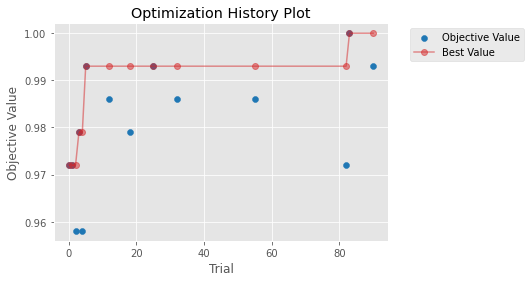

In [24]:
plot_optimization_history(study)

#### Visualize the learning curves of the trials. 
See :func:`~optuna.visualization.plot_intermediate_values` for the details.

C:\Users\user\AppData\Local\Temp\ipykernel_13184\3988485508.py:1: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(study)


<AxesSubplot:title={'center':'Intermediate Values Plot'}, xlabel='Step', ylabel='Intermediate Value'>

C:\Users\user\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


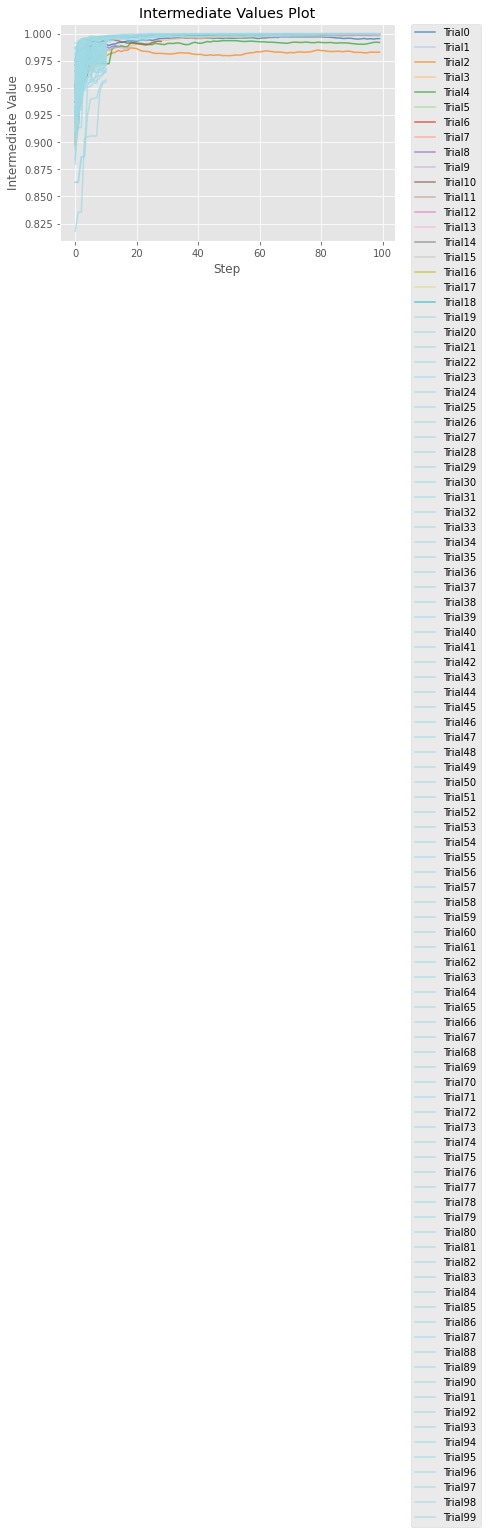

In [7]:
plot_intermediate_values(study)

#### Visualize high-dimensional parameter relationships. 
See :func:`~optuna.visualization.plot_parallel_coordinate` for the details.

C:\Users\user\AppData\Local\Temp\ipykernel_13184\4291280223.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


<AxesSubplot:title={'center':'Parallel Coordinate Plot'}>

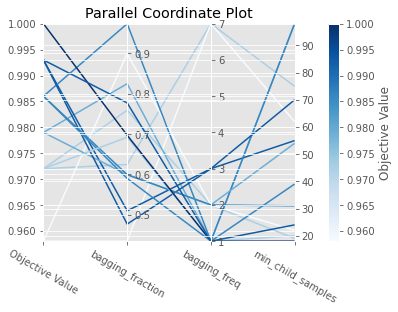

In [8]:
plot_parallel_coordinate(study)

#### Select parameters to visualize parameter relationships

C:\Users\user\AppData\Local\Temp\ipykernel_13184\2429126244.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study, params=["bagging_freq", "bagging_fraction"])


<AxesSubplot:title={'center':'Parallel Coordinate Plot'}>

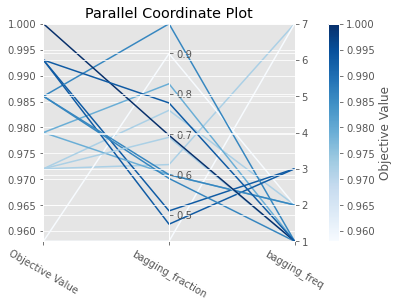

In [9]:
plot_parallel_coordinate(study, params=["bagging_freq", "bagging_fraction"])

#### Visualize hyperparameter relationships. 
See :func:`~optuna.visualization.plot_contour` for the details

C:\Users\user\AppData\Local\Temp\ipykernel_13184\927314822.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2022-08-30 20:31:39,178] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


array([[<AxesSubplot:ylabel='bagging_fraction'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='bagging_freq'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='bagging_fraction', ylabel='min_child_samples'>,
        <AxesSubplot:xlabel='bagging_freq'>,
        <AxesSubplot:xlabel='min_child_samples'>]], dtype=object)

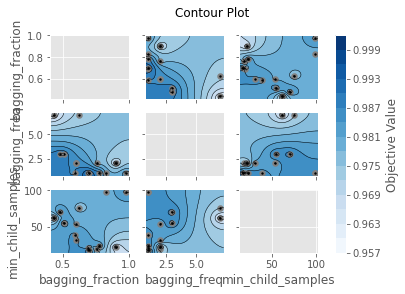

In [10]:
plot_contour(study)

#### Select parameters to visualize hyperparameter relationships

C:\Users\user\AppData\Local\Temp\ipykernel_13184\4130756127.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study, params=["bagging_freq", "bagging_fraction"])
[W 2022-08-30 20:32:02,977] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


<AxesSubplot:title={'center':'Contour Plot'}, xlabel='bagging_fraction', ylabel='bagging_freq'>

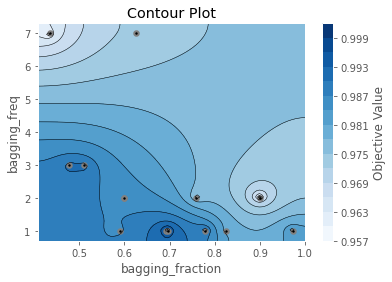

In [11]:
plot_contour(study, params=["bagging_freq", "bagging_fraction"])

#### Visualize individual hyperparameters as slice plot. 
See :func:`~optuna.visualization.plot_slice` for the details.

C:\Users\user\AppData\Local\Temp\ipykernel_13184\2457830863.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<AxesSubplot:xlabel='bagging_fraction', ylabel='Objective Value'>,
       <AxesSubplot:xlabel='bagging_freq'>,
       <AxesSubplot:xlabel='min_child_samples'>], dtype=object)

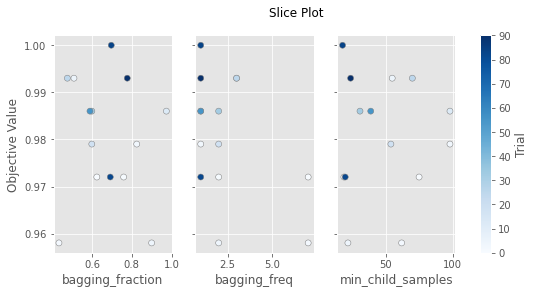

In [12]:
plot_slice(study)

#### Select parameters to visualize individual hyperparameters as slice plot.

C:\Users\user\AppData\Local\Temp\ipykernel_13184\2477807950.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study, params=["bagging_freq", "bagging_fraction"])


array([<AxesSubplot:xlabel='bagging_fraction', ylabel='Objective Value'>,
       <AxesSubplot:xlabel='bagging_freq'>], dtype=object)

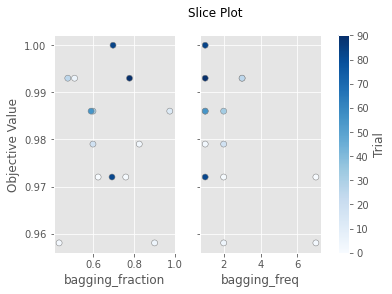

In [13]:
plot_slice(study, params=["bagging_freq", "bagging_fraction"])

#### Visualize parameter importances. 
See :func:`~optuna.visualization.plot_param_importances` for the details.

C:\Users\user\AppData\Local\Temp\ipykernel_13184\3836449081.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

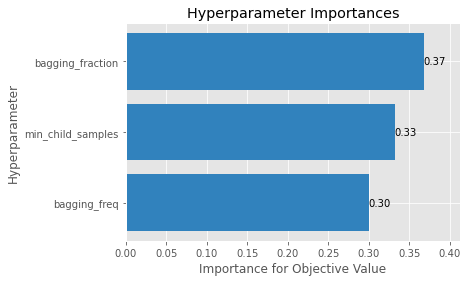

In [14]:
plot_param_importances(study)

#### Learn which hyperparameters are affecting the trial duration with hyperparameter importance.

C:\Users\user\AppData\Local\Temp\ipykernel_13184\1668215570.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study, target=lambda t: t.duration.total_seconds(), target_name="duration")


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for duration', ylabel='Hyperparameter'>

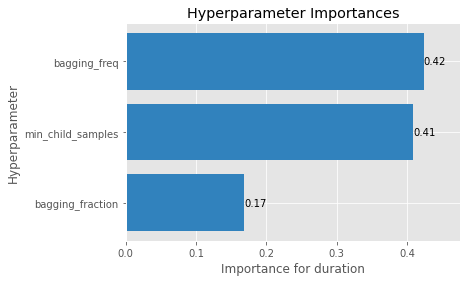

In [15]:
plot_param_importances(study, target=lambda t: t.duration.total_seconds(), target_name="duration")

#### Visualize empirical distribution function. 
See :func:`~optuna.visualization.plot_edf` for the details.

C:\Users\user\AppData\Local\Temp\ipykernel_13184\2521976691.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  plot_edf(study)


<AxesSubplot:title={'center':'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

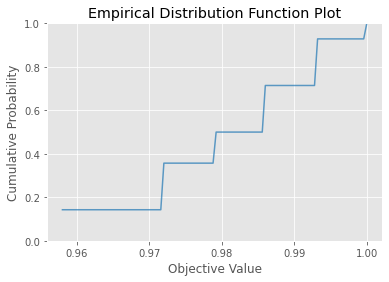

In [16]:
plot_edf(study)